<a href="https://colab.research.google.com/github/pegah-coder/eeg-analysis-with-matlab/blob/main/ERPclustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install mne
import mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 47.9 MB/s eta 0:00:00


In [13]:
import os
import numpy as np
import scipy.io as sio
import scipy.signal as signal
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Step 1: Load L5 channels from MATLAB ---
def get_l5_channels(directory, mat_filename="AE0004_chInfo.mat"):
    mat_path = os.path.join(directory, mat_filename)
    print(f"Looking for {mat_path} ...")
    mat_data = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)
    Ch = mat_data['Ch']
    aud_matrix = Ch.AUD
    layers = [str(l) for l in aud_matrix[0, :]]
    channels = aud_matrix[1, :].tolist()
    print("Length of layers:", len(layers))
    print("Length of channels:", len(channels))
    l5_channels = [channels[i] for i, layer in enumerate(layers) if layer == "L5"]
    return l5_channels, channels, layers

# --- Replace with the path in your Google Drive ---
directory = "/content/drive/MyDrive/SAMPLE/AE0004-02/AE0004-02-04-2023-12-15"

# Run the function
l5_channels, channels, layers = get_l5_channels(directory)
print("L5 channels:", l5_channels)
print("All channels:", channels)
print("All layers:", layers)


# --- Step 2: Load raw LFP ---
filename = "AE0004-02-04.lfp"
n_channels = len(channels)  # Calculate total channels from channels list
fs = 1250  # Sampling rate, matching MATLAB's calculated fs

lfp_path = os.path.join(directory, filename)
data_int16 = np.fromfile(lfp_path, dtype=np.int16)
n_samples = len(data_int16) // n_channels
lfp_data = data_int16[:n_samples*n_channels].reshape((n_samples, n_channels)).astype(np.float64)
time_data = np.arange(n_samples) / fs

# --- Step 3: Scale LFP to volts ---
lFPCh = lfp_data * 0.195  # Convert to volts, like MATLAB

print("\n=== Raw LFP Data Preview (first 10 rows, microvolts) ===")
print(lfp_data[:10, :])
print("\n=== Raw LFP Data Preview (first 10 rows, volts, L5 channel) ===")
print(lFPCh[:10, l5_channels[0]-1])  # L5 channel (channel 1, index 0)
print("\n=== Time Data Preview (first 10 values, seconds) ===")
print(time_data[:10])

# --- Step 4: Apply filters to all channels ---
filtered_lfp = np.zeros_like(lFPCh)  # Array for filtered signals
notched_lfp = np.zeros_like(lFPCh)   # Array for notched signals

# 60 Hz notch filter
f0 = 60  # Notch frequency
Q = 30   # Quality factor (try adjusting if mismatch persists)
b_notch, a_notch = signal.iirnotch(f0, Q, fs)

# 0.5-300 Hz bandpass filter
lowcut = 0.5
highcut = 300
order = 4  # Try order=2 or 6 if mismatch persists
b_band, a_band = signal.butter(order, [lowcut, highcut], btype='band', fs=fs)

for ch in range(n_channels):
    ch_signal = lFPCh[:, ch]  # Current channel signal in volts
    notched = signal.filtfilt(b_notch, a_notch, ch_signal)  # Apply notch filter
    notched_lfp[:, ch] = notched
    filtered_lfp[:, ch] = signal.filtfilt(b_band, a_band, notched)  # Apply bandpass filter

print("\n=== Notched LFP Data Preview (first 10 rows, volts, L5 channel) ===")
print(notched_lfp[:10, l5_channels[0]-1])  # L5 channel
print("\n=== Filtered LFP Data Preview (first 10 rows, volts, L5 channel) ===")
print(filtered_lfp[:10, l5_channels[0]-1])  # Compare with MATLAB [-54.7536721991378, ...]

# --- Step 5: Organize data with descriptors ---
descript = ['Layer', 'Channel #', 'Raw Data', 'Filtered Data [0.5-300]']
data_struct = {}
for ch in range(n_channels):
    data_struct[ch] = {
        'Layer': layers[ch] if ch < len(layers) else f'Unknown Layer {ch+1}',
        'Channel #': channels[ch],
        'Raw Data': lFPCh[:, ch],
        'Filtered Data [0.5-300]': filtered_lfp[:, ch]
    }

# --- Step 6: Interactive scrollable plot of all filtered channels using ipywidgets ---
import ipywidgets as widgets
from IPython.display import display, clear_output

window_sec = 5
window_samples = int(window_sec * fs)
max_idx = len(time_data) // window_samples - 1

def plot_window(idx):
    start_idx = idx * window_samples
    end_idx = start_idx + window_samples
    if end_idx > len(time_data):
        end_idx = len(time_data)
    clear_output(wait=True)
    fig, axs = plt.subplots(n_channels, 1, figsize=(12, 3 * n_channels), sharex=True)
    for ch in range(n_channels):
        axs[ch].plot(time_data[start_idx:end_idx], filtered_lfp[start_idx:end_idx, ch])
        axs[ch].set_ylabel('Voltage (V)')
        axs[ch].set_title(
            f'Filtered LFP (Channel {channels[ch]}, Layer: {data_struct[ch]["Layer"]}, 0.5-300 Hz)'
        )
    axs[-1].set_xlabel('Time (s)')
    plt.show()

slider = widgets.IntSlider(min=0, max=max_idx, step=1, value=0, description="Window")
widgets.interact(plot_window, idx=slider)

import mne

# --- Step 7: Wrap filtered LFP into an MNE Raw object ---
# Build channel names from your existing info
ch_names = [f"Ch{channels[ch]}_{data_struct[ch]['Layer']}" for ch in range(n_channels)]

# Sampling frequency
sfreq = fs

# MNE expects (n_channels, n_times) instead of (n_times, n_channels)
data_for_mne = filtered_lfp.T

# Create channel info (all EEG-type, but you can set 'ecog' or 'seeg' if needed)
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types="eeg")

# Create Raw object
raw = mne.io.RawArray(data_for_mne, info)

print(raw)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking for /content/drive/MyDrive/SAMPLE/AE0004-02/AE0004-02-04-2023-12-15/AE0004_chInfo.mat ...
Length of layers: 3
Length of channels: 3
L5 channels: [1]
All channels: [1, 2, 3]
All layers: ['L5', 'L5a', 'L5b']

=== Raw LFP Data Preview (first 10 rows, microvolts) ===
[[  -8. -244. -268.]
 [  41. -449. -464.]
 [ 179. -253. -275.]
 [ 253. -185. -232.]
 [ 179. -263. -318.]
 [  98. -375. -430.]
 [ 108. -417. -488.]
 [ 190. -353. -420.]
 [ 286. -294. -330.]
 [ 347. -254. -299.]]

=== Raw LFP Data Preview (first 10 rows, volts, L5 channel) ===
[-1.56   7.995 34.905 49.335 34.905 19.11  21.06  37.05  55.77  67.665]

=== Time Data Preview (first 10 values, seconds) ===
[0.     0.0008 0.0016 0.0024 0.0032 0.004  0.0048 0.0056 0.0064 0.0072]

=== Notched LFP Data Preview (first 10 rows, volts, L5 channel) ===
[ 5.57198505 13.57390729 38.40998667 50.42899511 33.4660

interactive(children=(IntSlider(value=0, description='Window', max=113), Output()), _dom_classes=('widget-inte…

Creating RawArray with float64 data, n_channels=3, n_times=716269
    Range : 0 ... 716268 =      0.000 ...   573.014 secs
Ready.
<RawArray | 3 x 716269 (573.0 s), ~16.4 MiB, data loaded>


First 10 timestamps (s): [33.1072 35.6072 38.1071 40.6071 43.1071 45.6071 48.1071 50.607  53.107
 55.607 ]
First 10 descriptions: ['Aud', 'Aud', 'Aud', 'Aud', 'Aud', 'Aud', 'Aud', 'Aud', 'Aud', 'Aud']
Total auditory events: 200
Detected 100 events at 5 Hz
Detected 100 events at 10 Hz
Total events: 200
Creating RawArray with float64 data, n_channels=3, n_times=716269
    Range : 0 ... 716268 =      0.000 ...   573.014 secs
Ready.
Not setting metadata
200 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 1251 original time points ...
0 bad epochs dropped
<Epochs | 200 events (all good), -0.2 – 0.8 s (baseline -0.2 – 0 s), ~5.7 MiB, data loaded,
 'Tone5Hz': 100
 'Tone10Hz': 100>
Using matplotlib as 2D backend.


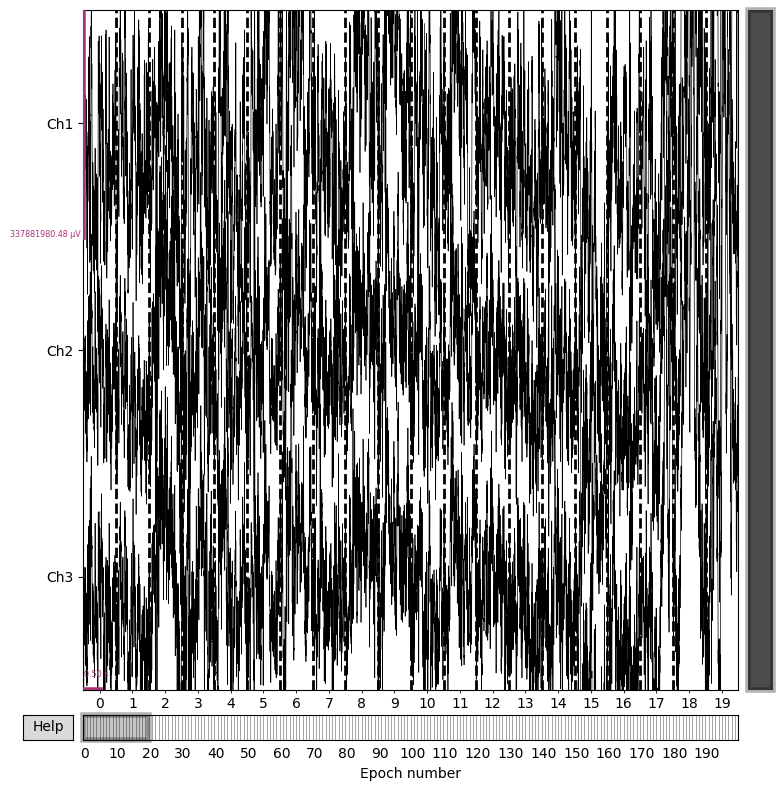

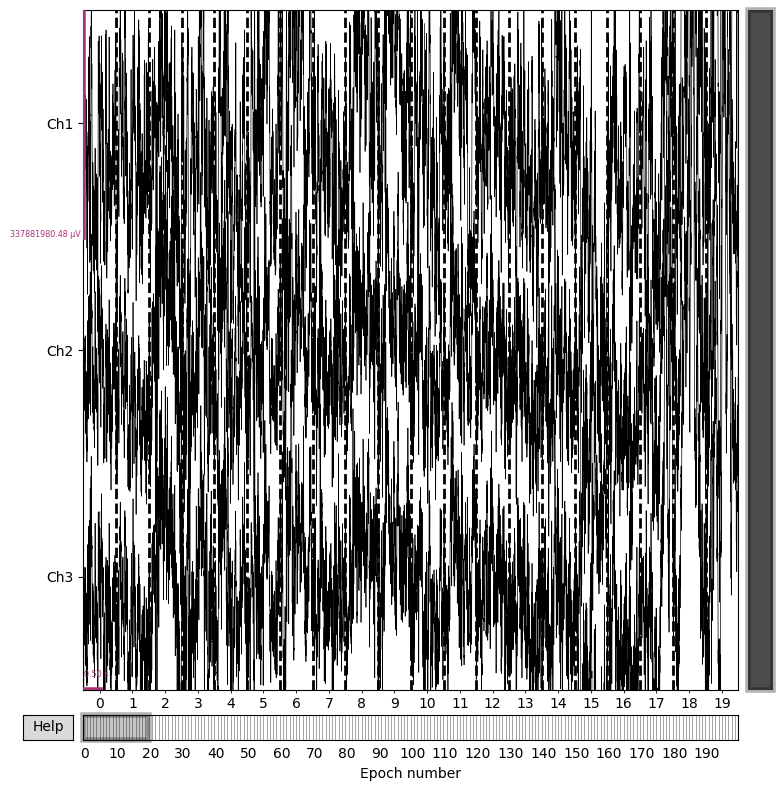

In [28]:
# === Part 2: Load events and perform ERP analysis with events in seconds ===
import numpy as np
import mne

# --- Event file ---
evt_file = os.path.join(directory, "AE0004-02-04.ALL.evt")

# --- Load Neuralynx .evt file ---
def load_neuralynx_events(evt_file):
    times = []
    desc = []
    with open(evt_file, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                times.append(float(parts[0]))
                desc.append(parts[1])
    times = np.array(times) / 1000.0  # convert ms → seconds
    return times, desc

event_times, event_desc = load_neuralynx_events(evt_file)
print("First 10 timestamps (s):", event_times[:10])
print("First 10 descriptions:", event_desc[:10])

# --- Extract auditory events ---
aud_idx = [i for i, d in enumerate(event_desc) if d == "Aud"]
AudEvtPT = event_times[aud_idx]  # still in seconds
print(f"Total auditory events: {len(AudEvtPT)}")

# --- Split 5 kHz / 10 kHz using known sequence (100 each) ---
IdTone1 = np.arange(0, 100)    # first 100 events = 5 kHz
IdTone2 = np.arange(100, 200)  # next 100 events = 10 kHz
AudEvt5hz_sec = [AudEvtPT[i] for i in IdTone1]
AudEvt10hz_sec = [AudEvtPT[i] for i in IdTone2]

# --- Convert to sample indices for MNE ---
fs = 1250  # sampling rate
AudEvt5hz_samples = (np.array(AudEvt5hz_sec) * fs).astype(int)
AudEvt10hz_samples = (np.array(AudEvt10hz_sec) * fs).astype(int)

# --- Combine events and ensure valid indices inside raw data ---
events_5hz = np.column_stack((AudEvt5hz_samples,
                              np.zeros(len(AudEvt5hz_samples), dtype=int),
                              np.ones(len(AudEvt5hz_samples), dtype=int)))
events_10hz = np.column_stack((AudEvt10hz_samples,
                               np.zeros(len(AudEvt10hz_samples), dtype=int),
                               2*np.ones(len(AudEvt10hz_samples), dtype=int)))
events = np.vstack((events_5hz, events_10hz))
events = events[np.argsort(events[:, 0])]  # sort by sample

# --- Keep only events that fit within LFP data considering tmin/tmax ---
tmin, tmax = -0.2, 0.8
valid_idx = (events[:,0] + int(tmin*fs) >= 0) & (events[:,0] + int(tmax*fs) < filtered_lfp.shape[0])
events = events[valid_idx]

print(f"Detected {np.sum(events[:,2]==1)} events at 5 Hz")
print(f"Detected {np.sum(events[:,2]==2)} events at 10 Hz")
print(f"Total events: {len(events)}")

# --- Store events in seconds for reference ---
events_sec = {'Tone5Hz': AudEvt5hz_sec, 'Tone10Hz': AudEvt10hz_sec}

# --- Build MNE Raw object ---
info = mne.create_info(ch_names=[f'Ch{i+1}' for i in range(n_channels)], sfreq=fs, ch_types='eeg')
raw = mne.io.RawArray(filtered_lfp.T, info)

# --- Epoch data ---
epochs = mne.Epochs(raw, events, event_id={"Tone5Hz": 1, "Tone10Hz": 2},
                    tmin=tmin, tmax=tmax, baseline=(None,0), preload=True)

print(epochs)
epochs.plot(n_channels=n_channels, scalings='auto')


In [29]:
# === Part 1: Interactive LFP plotting with events in seconds ===
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np

# window for plotting
window_sec = 5
window_samples = int(window_sec * fs)
max_idx = len(time_data) // window_samples - 1

# channels
channels = [f'Ch{i+1}' for i in range(n_channels)]
data_struct = {ch: {"Layer": "Unknown"} for ch in range(n_channels)}

# Example: events_sec from Part 2
# events_sec = {'Tone5Hz': AudEvt5hz_sec, 'Tone10Hz': AudEvt10hz_sec}

def plot_window(idx):
    start_idx = idx * window_samples
    end_idx = start_idx + window_samples
    if end_idx > len(time_data):
        end_idx = len(time_data)
    clear_output(wait=True)
    fig, axs = plt.subplots(n_channels, 1, figsize=(12, 3 * n_channels), sharex=True)
    for ch in range(n_channels):
        axs[ch].plot(time_data[start_idx:end_idx], filtered_lfp[start_idx:end_idx, ch], color='tab:blue')
        axs[ch].set_ylabel('Voltage (V)')
        axs[ch].set_title(
            f'Filtered LFP (Channel {channels[ch]}, Layer: {data_struct[ch]["Layer"]}, 0.5-300 Hz)'
        )
        # --- Overlay events ---
        for ev in events_sec['Tone5Hz']:
            if start_idx/fs <= ev <= end_idx/fs:
                axs[ch].axvline(ev, color='red', linestyle='--', alpha=0.7, label='5 kHz')
        for ev in events_sec['Tone10Hz']:
            if start_idx/fs <= ev <= end_idx/fs:
                axs[ch].axvline(ev, color='green', linestyle='--', alpha=0.7, label='10 kHz')
        # Only show legend once
        if ch == 0:
            axs[ch].legend(['LFP', '5 kHz', '10 kHz'])
    axs[-1].set_xlabel('Time (s)')
    plt.show()

slider = widgets.IntSlider(min=0, max=max_idx, step=1, value=0, description="Window")
widgets.interact(plot_window, idx=slider)


interactive(children=(IntSlider(value=0, description='Window', max=113), Output()), _dom_classes=('widget-inte…

<function __main__.plot_window(idx)>